In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Bidirectional,GRU
import tensorflow as tf

In [2]:
tf.random.set_seed(42)

In [3]:
def evaluation_metrics(Y_test, preds):
    # Creating a confusion matrix
    cm = confusion_matrix(Y_test, preds)

    # Printing the classification report
    print(classification_report(Y_test, preds))

    # Printing the F1 Score
    print("F1 Score: ", f1_score(Y_test, preds, average='weighted'))
    
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
    plt.title('Confusion Matrix')
    plt.xlabel('Y predict')
    plt.ylabel('Y test')
    plt.show()
    

In [4]:
# Reshape the data for LSTM
def create_sequences(data, target, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [5]:
# Reading Train Datasets
df_M0000=pd.read_csv(r'E:\Havelsan\Datasets\M0000_train_sensors.csv', engine='c')
df_M0000['target'] = 0
df_M2503=pd.read_csv(r'E:\Havelsan\Datasets\M2503_train_sensors.csv', engine='c')
df_M2503['target'] = 1
df_M2508=pd.read_csv(r'E:\Havelsan\Datasets\M2508_train_sensors.csv', engine='c')
df_M2508['target'] = 2
df1 = pd.concat([df_M0000,df_M2503,df_M2508], axis=0)
df1

,Time,Load,SeaTemp,WindSpeed,RunId,E02005,E02006,E02056,E03760,G00027,...,Z00518,Z00770,Z01970,Z02013,Z02436,Z02437,Z02477,Z02482,Linear,target
0,00:00:00,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1410,0
1,00:00:01,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1409,0
2,00:00:02,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1408,0
3,00:00:03,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1407,0
4,00:00:04,FAL,SW20,WC0,1,16.7659,430.9120,3647.98,16.5258,3.17649,...,12.9311,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706371,00:22:12,FAU,SW28,WC6,35,12.4602,25.1648,2757.11,12.3641,2.87130,...,16.0775,6,15.7389,31.6045,0.0,1.0,0.0,0.0,4,2
706372,00:22:13,FAU,SW28,WC6,35,12.4691,25.1000,2757.11,12.3815,2.87130,...,16.0790,6,15.7460,31.6222,0.0,1.0,0.0,0.0,3,2
706373,00:22:14,FAU,SW28,WC6,35,12.4781,25.0352,2757.11,12.3989,2.87130,...,16.0804,6,15.7530,31.6398,0.0,1.0,0.0,0.0,2,2
706374,00:22:15,FAU,SW28,WC6,35,12.4870,24.9703,2757.11,12.4163,2.87130,...,16.0819,6,15.7601,31.6574,0.0,1.0,0.0,0.0,1,2


In [6]:
result=df1
abr_sensor_list = ['E02005', 'E02006', 'E02056', 'E03760', 'G00027', 'G00108', 'G02011', 'N02015', 'P00023', 'P01005', 'P01302', 'P01303', 'P01600', 'P01602', 'P02055', 'P02065', 'P02066', 'P02071', 'P02072', 'Q02004', 'T00002', 'T01010', 'T01011', 'T01350', 'T01351', 'T01601', 'T01603', 'T02014', 'T02040', 'T02041', 'T02042', 'T02044', 'T04600', 'Z00518', 'Z01970', 'Z02013']
df_train=result[abr_sensor_list+['target','Time','RunId','SeaTemp','WindSpeed','Load']]
df_train.dropna(inplace=True)
df_train.reset_index(drop=True,inplace=True)

C:\Users\anilo\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [7]:
# convert the conditions to string type
df_train['target'] = df_train['target'].astype(str)
df_train['RunId'] = df_train['RunId'].astype(str)
df_train['UniqueRunId'] = df_train['target'] + '_' + df_train['SeaTemp'] + '_' + df_train['WindSpeed'] + '_' + df_train['Load'] + '_' + df_train['RunId']
df_train['target'] = df_train['target'].astype(int)
df_train['Time'] = pd.to_timedelta(df_train['Time']).dt.total_seconds()
df_train.drop(columns=['RunId'],inplace=True)
df_train

C:\Users\anilo\AppData\Local\Temp/ipykernel_15364/4216835862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target'] = df_train['target'].astype(str)
C:\Users\anilo\AppData\Local\Temp/ipykernel_15364/4216835862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['RunId'] = df_train['RunId'].astype(str)
C:\Users\anilo\AppData\Local\Temp/ipykernel_15364/4216835862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T04600,Z00518,Z01970,Z02013,target,Time,SeaTemp,WindSpeed,Load,UniqueRunId
0,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,0.0,SW20,WC0,FAL,0_SW20_WC0_FAL_1
1,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,1.0,SW20,WC0,FAL,0_SW20_WC0_FAL_1
2,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,2.0,SW20,WC0,FAL,0_SW20_WC0_FAL_1
3,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,3.0,SW20,WC0,FAL,0_SW20_WC0_FAL_1
4,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,4.0,SW20,WC0,FAL,0_SW20_WC0_FAL_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235791,12.4602,25.1648,2757.11,12.3641,2.87130,3.08811,2.87402,67.0734,7.72496,2.14855,...,300.477,16.0775,15.7389,31.6045,2,1332.0,SW28,WC6,FAU,2_SW28_WC6_FAU_35
2235792,12.4691,25.1000,2757.11,12.3815,2.87130,3.08950,2.87441,67.0529,7.72578,2.14846,...,300.439,16.0790,15.7460,31.6222,2,1333.0,SW28,WC6,FAU,2_SW28_WC6_FAU_35
2235793,12.4781,25.0352,2757.11,12.3989,2.87130,3.09090,2.87480,67.0323,7.72661,2.14838,...,300.400,16.0804,15.7530,31.6398,2,1334.0,SW28,WC6,FAU,2_SW28_WC6_FAU_35
2235794,12.4870,24.9703,2757.11,12.4163,2.87130,3.09229,2.87519,67.0117,7.72743,2.14829,...,300.361,16.0819,15.7601,31.6574,2,1335.0,SW28,WC6,FAU,2_SW28_WC6_FAU_35


In [8]:
# Reading Test Datasets
df_M0000=pd.read_csv(r'E:\Havelsan\Datasets\M0000_test_sensors.csv', engine='c')
df_M0000['target'] = 0
df_M2503=pd.read_csv(r'E:\Havelsan\Datasets\M2503_test_sensors.csv', engine='c')
df_M2503['target'] = 1
df_M2508=pd.read_csv(r'E:\Havelsan\Datasets\M2508_test_sensors.csv', engine='c')
df_M2508['target'] = 2
df2 = pd.concat([df_M0000,df_M2503,df_M2508], axis=0)
df2

,Time,Load,SeaTemp,WindSpeed,RunId,E02005,E02006,E02056,E03760,G00027,...,Z00518,Z00770,Z01970,Z02013,Z02436,Z02437,Z02477,Z02482,Linear,target
0,00:00:00,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1413,0
1,00:00:01,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1412,0
2,00:00:02,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1411,0
3,00:00:03,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1410,0
4,00:00:04,FAL,SW20,WC0,36,16.7659,430.9120,3647.98,NaN,3.17649,...,NaN,0,14.9813,22.5320,0.0,0.0,0.0,0.0,1409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363102,00:21:11,FAU,SW28,WC6,53,12.2713,24.8041,2854.77,11.3117,2.84142,...,16.2002,6,15.8048,32.3668,0.0,1.0,0.0,0.0,4,2
363103,00:21:12,FAU,SW28,WC6,53,12.2393,24.7914,2854.77,11.1414,2.83280,...,16.1980,6,15.8072,32.1289,0.0,1.0,0.0,0.0,3,2
363104,00:21:13,FAU,SW28,WC6,53,12.2073,24.7788,2854.77,10.9711,2.82417,...,16.1958,6,15.8096,31.8910,0.0,1.0,0.0,0.0,2,2
363105,00:21:14,FAU,SW28,WC6,53,12.4152,24.9221,2854.77,12.1801,2.86838,...,16.1937,6,15.8288,31.8499,0.0,1.0,0.0,0.0,1,2


In [9]:
result=df2
abr_sensor_list = ['E02005', 'E02006', 'E02056', 'E03760', 'G00027', 'G00108', 'G02011', 'N02015', 'P00023', 'P01005', 'P01302', 'P01303', 'P01600', 'P01602', 'P02055', 'P02065', 'P02066', 'P02071', 'P02072', 'Q02004', 'T00002', 'T01010', 'T01011', 'T01350', 'T01351', 'T01601', 'T01603', 'T02014', 'T02040', 'T02041', 'T02042', 'T02044', 'T04600', 'Z00518', 'Z01970', 'Z02013']
df_test=result[abr_sensor_list+['target','Time','RunId','SeaTemp','WindSpeed','Load']]
df_test.dropna(inplace=True)
df_test.reset_index(drop=True,inplace=True)

C:\Users\anilo\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
# convert the conditions to string type
df_test['target'] = df_test['target'].astype(str)
df_test['RunId'] = df_test['RunId'].astype(str)
df_test['UniqueRunId'] = df_test['target'] + '_' + df_test['SeaTemp'] + '_' + df_test['WindSpeed'] + '_' + df_test['Load'] + '_' + df_test['RunId']
df_test['target'] = df_test['target'].astype(int)
df_test['Time'] = pd.to_timedelta(df_test['Time']).dt.total_seconds()
df_test.drop(columns=['RunId'],inplace=True)
df_test

C:\Users\anilo\AppData\Local\Temp/ipykernel_15364/1810049662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target'] = df_test['target'].astype(str)
C:\Users\anilo\AppData\Local\Temp/ipykernel_15364/1810049662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['RunId'] = df_test['RunId'].astype(str)
C:\Users\anilo\AppData\Local\Temp/ipykernel_15364/1810049662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T04600,Z00518,Z01970,Z02013,target,Time,SeaTemp,WindSpeed,Load,UniqueRunId
0,16.7722,432.7310,3647.98,16.5320,3.17834,3.43379,3.17827,74.0099,7.63862,2.15110,...,234.325,12.9326,14.9730,22.5361,0,8.0,SW20,WC0,FAL,0_SW20_WC0_FAL_36
1,16.7722,430.4790,3647.98,16.5320,3.17804,3.43365,3.17797,74.0099,7.63862,2.15192,...,234.329,12.9326,14.9747,22.5361,0,9.0,SW20,WC0,FAL,0_SW20_WC0_FAL_36
2,16.7722,428.2280,3647.98,16.5320,3.17774,3.43352,3.17767,74.0099,7.63878,2.15274,...,234.333,12.9326,14.9764,22.5361,0,10.0,SW20,WC0,FAL,0_SW20_WC0_FAL_36
3,16.7716,427.8040,3647.98,16.5315,3.17747,3.43323,3.17741,74.0096,7.63886,2.15277,...,234.339,12.9326,14.9774,22.5357,0,11.0,SW20,WC0,FAL,0_SW20_WC0_FAL_36
4,16.7710,427.3800,3647.98,16.5309,3.17721,3.43294,3.17714,74.0092,7.63894,2.15279,...,234.345,12.9326,14.9784,22.5354,0,12.0,SW20,WC0,FAL,0_SW20_WC0_FAL_36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152217,12.2713,24.8041,2854.77,11.3117,2.84142,3.10566,2.84066,66.2408,7.74033,2.15153,...,302.676,16.2002,15.8048,32.3668,2,1271.0,SW28,WC6,FAU,2_SW28_WC6_FAU_53
1152218,12.2393,24.7914,2854.77,11.1414,2.83280,3.10399,2.83242,66.1479,7.74267,2.15147,...,302.657,16.1980,15.8072,32.1289,2,1272.0,SW28,WC6,FAU,2_SW28_WC6_FAU_53
1152219,12.2073,24.7788,2854.77,10.9711,2.82417,3.10231,2.82417,66.0550,7.74500,2.15141,...,302.638,16.1958,15.8096,31.8910,2,1273.0,SW28,WC6,FAU,2_SW28_WC6_FAU_53
1152220,12.4152,24.9221,2854.77,12.1801,2.86838,3.09923,2.86838,67.0868,7.73741,2.15215,...,302.622,16.1937,15.8288,31.8499,2,1274.0,SW28,WC6,FAU,2_SW28_WC6_FAU_53


In [11]:
df_train_frequency=df_train.copy()
Load_fe = df_train_frequency.groupby('Load').size()/len(df_train_frequency)
WindSpeed_fe = df_train_frequency.groupby('WindSpeed').size()/len(df_train_frequency)
SeaTemp_fe = df_train_frequency.groupby('SeaTemp').size()/len(df_train_frequency)
df_train_frequency.loc[:, 'Load'] = df_train_frequency['Load'].map(Load_fe)
df_train_frequency.loc[:, 'WindSpeed'] = df_train_frequency['WindSpeed'].map(WindSpeed_fe)
df_train_frequency.loc[:, 'SeaTemp'] = df_train_frequency['SeaTemp'].map(SeaTemp_fe)
df_test_frequency=df_test.copy()
Load_fe = df_test_frequency.groupby('Load').size()/len(df_test_frequency)
WindSpeed_fe = df_test_frequency.groupby('WindSpeed').size()/len(df_test_frequency)
SeaTemp_fe = df_test_frequency.groupby('SeaTemp').size()/len(df_test_frequency)
df_test_frequency.loc[:, 'Load'] = df_test_frequency['Load'].map(Load_fe)
df_test_frequency.loc[:, 'WindSpeed'] = df_test_frequency['WindSpeed'].map(WindSpeed_fe)
df_test_frequency.loc[:, 'SeaTemp'] = df_test_frequency['SeaTemp'].map(SeaTemp_fe)

In [12]:
df_train_frequency

,E02005,E02006,E02056,E03760,G00027,G00108,G02011,N02015,P00023,P01005,...,T04600,Z00518,Z01970,Z02013,target,Time,SeaTemp,WindSpeed,Load,UniqueRunId
0,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,0.0,0.33381,0.330756,0.503727,0_SW20_WC0_FAL_1
1,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,1.0,0.33381,0.330756,0.503727,0_SW20_WC0_FAL_1
2,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,2.0,0.33381,0.330756,0.503727,0_SW20_WC0_FAL_1
3,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,3.0,0.33381,0.330756,0.503727,0_SW20_WC0_FAL_1
4,16.7659,430.9120,3647.98,16.5258,3.17649,3.43147,3.17649,74.0058,7.63919,2.15155,...,234.325,12.9311,14.9813,22.5320,0,4.0,0.33381,0.330756,0.503727,0_SW20_WC0_FAL_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235791,12.4602,25.1648,2757.11,12.3641,2.87130,3.08811,2.87402,67.0734,7.72496,2.14855,...,300.477,16.0775,15.7389,31.6045,2,1332.0,0.33866,0.336879,0.496273,2_SW28_WC6_FAU_35
2235792,12.4691,25.1000,2757.11,12.3815,2.87130,3.08950,2.87441,67.0529,7.72578,2.14846,...,300.439,16.0790,15.7460,31.6222,2,1333.0,0.33866,0.336879,0.496273,2_SW28_WC6_FAU_35
2235793,12.4781,25.0352,2757.11,12.3989,2.87130,3.09090,2.87480,67.0323,7.72661,2.14838,...,300.400,16.0804,15.7530,31.6398,2,1334.0,0.33866,0.336879,0.496273,2_SW28_WC6_FAU_35
2235794,12.4870,24.9703,2757.11,12.4163,2.87130,3.09229,2.87519,67.0117,7.72743,2.14829,...,300.361,16.0819,15.7601,31.6574,2,1335.0,0.33866,0.336879,0.496273,2_SW28_WC6_FAU_35


In [13]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train_frequency.drop(columns=['target', 'UniqueRunId','Time']))
test_data_scaled = scaler.transform(df_test_frequency.drop(columns=['target', 'UniqueRunId','Time']))

In [14]:
target_train = to_categorical(df_train_frequency['target'])

# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_train_frequency['UniqueRunId'].unique():
    # Get data for the current run
    run_data = train_data_scaled[df_train_frequency['UniqueRunId'] == run_id]
    run_target = target_train[df_train_frequency['UniqueRunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_train = np.concatenate(sequences)
Y_train = np.concatenate(target_seq)
print("X train shape:",X_train.shape)
print("Y train shape:",Y_train.shape)

X train shape: (2196526, 20, 39)
Y train shape: (2196526, 3)


In [15]:
X_train

array([[[ 0.88826531,  1.44968305,  0.93227201, ...,  0.09095202,
         -1.00031816,  0.99257341],
        [ 0.88826531,  1.44968305,  0.93227201, ...,  0.09095202,
         -1.00031816,  0.99257341],
        [ 0.88826531,  1.44968305,  0.93227201, ...,  0.09095202,
         -1.00031816,  0.99257341],
        ...,
        [ 0.88954505,  1.40930994,  0.98222087, ...,  0.09095202,
         -1.00031816,  0.99257341],
        [ 0.88924035,  1.40426631,  0.98845822, ...,  0.09095202,
         -1.00031816,  0.99257341],
        [ 0.88893565,  1.39921466,  0.99469557, ...,  0.09095202,
         -1.00031816,  0.99257341]],

       [[ 0.88826531,  1.44968305,  0.93227201, ...,  0.09095202,
         -1.00031816,  0.99257341],
        [ 0.88826531,  1.44968305,  0.93227201, ...,  0.09095202,
         -1.00031816,  0.99257341],
        [ 0.88826531,  1.44968305,  0.93227201, ...,  0.09095202,
         -1.00031816,  0.99257341],
        ...,
        [ 0.88924035,  1.40426631,  0.98845822, ...,  

In [16]:
Y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [17]:
target_test = to_categorical(df_test_frequency['target'])


# Initialize lists to store sequences
sequences = []
target_seq = []

# Define sequence length
SEQ_LEN = 20

# Create sequences for each run separately
for run_id in df_test_frequency['UniqueRunId'].unique():
    # Get data for the current run
    run_data = test_data_scaled[df_test_frequency['UniqueRunId'] == run_id]
    run_target = target_test[df_test_frequency['UniqueRunId'] == run_id]
    
    # Create sequences for the current run
    run_sequences, run_target_seq = create_sequences(run_data, run_target, SEQ_LEN)
    
    # Append the sequences to the lists
    sequences.append(run_sequences)
    target_seq.append(run_target_seq)

# Convert lists to numpy arrays
X_test = np.concatenate(sequences)
Y_test = np.concatenate(target_seq)
print("X test shape:",X_test.shape)
print("Y test shape:",Y_test.shape)

X test shape: (1131999, 20, 39)
Y test shape: (1131999, 3)


**Test Case XVII**

In [18]:
# Define the LSTM model
model = Sequential()

model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32,  validation_split=0.2, callbacks=[early_stopping, lr_reduction])


Epoch 1/50
54914/54914 [==============================] - 3556s 63ms/step - loss: 0.0902 - accuracy: 0.9498 - val_loss: 0.8548 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 2/50
54914/54914 [==============================] - 1141s 21ms/step - loss: 0.0761 - accuracy: 0.9560 - val_loss: 2.0679 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 3/50
54914/54914 [==============================] - 1141s 21ms/step - loss: 0.0723 - accuracy: 0.9581 - val_loss: 1.7665 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 4/50
54914/54914 [==============================] - 1136s 21ms/step - loss: 0.0708 - accuracy: 0.9594 - val_loss: 2.0363 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 5/50
54914/54914 [==============================] - 1148s 21ms/step - loss: 0.0695 - accuracy: 0.9603 - val_loss: 1.6257 - val_accuracy: 0.8540 - lr: 0.0010
Epoch 6/50
54914/54914 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9611
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54914/549

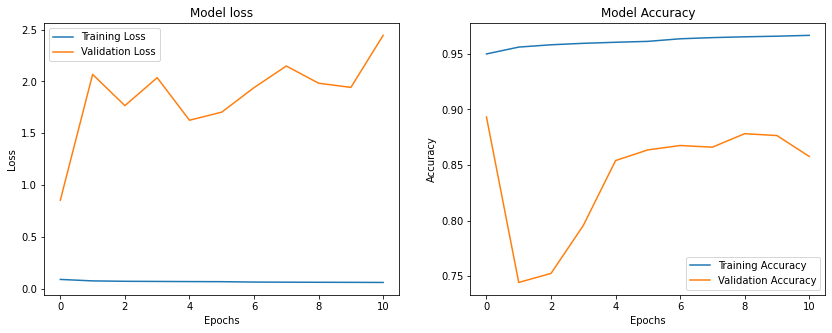

In [19]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

35375/35375 [==============================] - 430s 10ms/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.93    393747
           1       0.93      0.96      0.95    383991
           2       0.99      0.89      0.94    354261

    accuracy                           0.94   1131999
   macro avg       0.94      0.94      0.94   1131999
weighted avg       0.94      0.94      0.94   1131999

F1 Score:  0.9378056223849685


NameError: name 'sns' is not defined

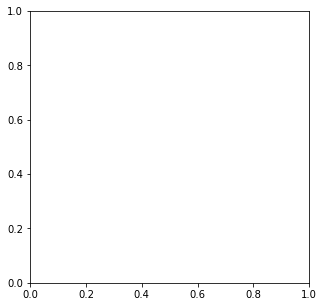

In [20]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)

**Test Case XIV**

In [ ]:
# Define the model
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
# Plot the loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(X_test)
preds = np.argmax(y_pred, axis=1)
y_test_1= np.argmax(Y_test, axis=1)
evaluation_metrics(y_test_1, preds)